## Simulation and correction of motion related artifact with parallel MRI

* Producing simulation data affected by motion artifact
* Using parallel MRI to produce aliasing-free images
* Using FSL to measure motion parameters (another notebook: step2)
* Using MUSE to combine motion-corrected data (see powerpoint slides)

In [1]:
push!(LOAD_PATH,"library");
using PyPlot
using NK_tools
using Read_NIfTI1_real

In [2]:
fid = open("data/kdata_2s_seepi");
kdata_2s_seepi = read(fid, Complex128,(128,128,8,2));
close(fid);

In [3]:
kdata_contrast1 = kdata_2s_seepi[:,:,:,1]; # not affected by motion artifact
kdata_contrast2 = kdata_2s_seepi[:,:,:,2];
i = complex(0,1);
kdata_contrast2[:,1:2:end,:] = kdata_contrast2[:,1:2:end,:].*exp.(i*2.4π*linspace(-63,64,128)/128);
kdata_contrast2[:,2:2:end,:] = kdata_contrast2[:,2:2:end,:].*exp.(i*5.2π*linspace(-63,64,128)/128).*exp(i*2π/3);


In [4]:
imgdata_contrast1 = qft(copy(kdata_contrast1));
imgdata_contrast2 = qft(copy(kdata_contrast2));

11796481179648

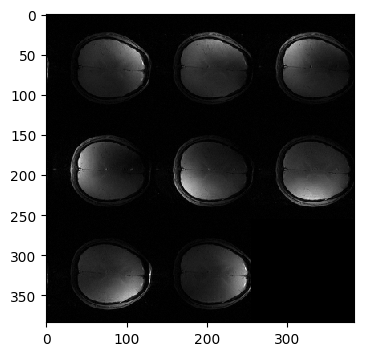

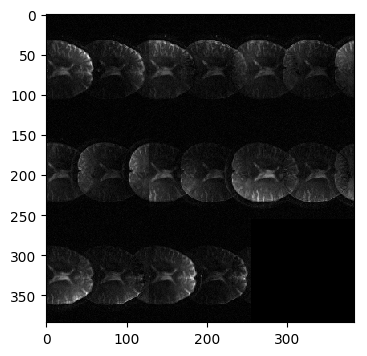

PyObject <matplotlib.image.AxesImage object at 0x2aab3bdcf860>

In [5]:
figure(1,figsize=(4,4));imal(abs.(imgdata_contrast1),3,3)
figure(2,figsize=(4,4));imal(abs.(imgdata_contrast2),3,3)

* __We could combine the information from 8 RF coil channels with "root-mean-square"__

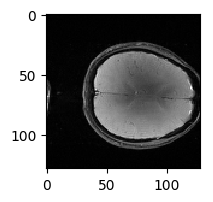

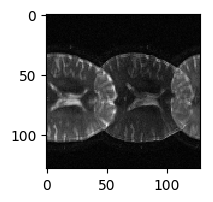

In [6]:
combinedData_contrast1 = rmsCombineDataCoils(imgdata_contrast1);
combinedData_contrast2 = rmsCombineDataCoils(imgdata_contrast2);
figure(1,figsize=(2,2));imshow(combinedData_contrast1[:,:,1],cmap="gray")
figure(2,figsize=(2,2));imshow(combinedData_contrast2[:,:,1],cmap="gray");


* __Calculation of coil sensitivity profiles from the first echo image__

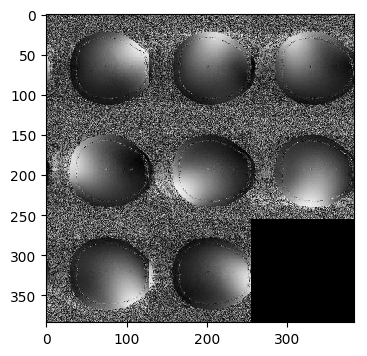

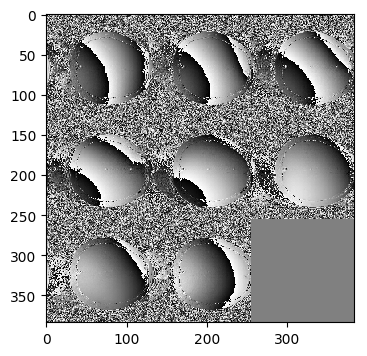

11796481179648

In [7]:
coilSensitivityProfile1 = imgdata_contrast1./combinedData_contrast1;
figure(1,figsize=(4,4));imal(abs.(coilSensitivityProfile1),3,3)
figure(2,figsize=(4,4));imal(angle.(coilSensitivityProfile1),3,3);

* __Assuming that we have only acquied 50% of the k-space data for echo image 2 (with only odd ky lines acquired), what would the reconstructed images look like?__

* __SENSE reconstruction of odd-ky-line data__

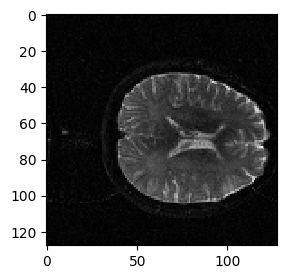

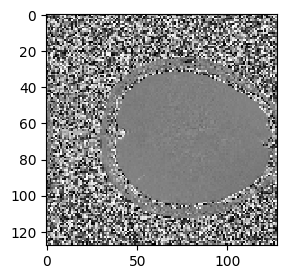

PyObject <matplotlib.image.AxesImage object at 0x2aab3c16e5c0>

In [8]:
oddkData_acquired_zeroFilled = zeros(Complex128,size(kdata_contrast2));
oddkData_acquired_zeroFilled[:,1:2:end,:] = kdata_contrast2[:,1:2:end,:];
oddimgdata_acquired_zeroFilled = qft(copy(oddkData_acquired_zeroFilled));
oddsense_reconstructed_image = zeros(Complex128,size(oddkData_acquired_zeroFilled)[1],size(oddkData_acquired_zeroFilled)[2]);
for cntx = 1:size(oddkData_acquired_zeroFilled)[1]
    for cnty = 1: div(size(oddkData_acquired_zeroFilled)[2],2)
        mat1 = oddimgdata_acquired_zeroFilled[cntx,cnty,:];
        mat2 = hcat(coilSensitivityProfile1[cntx,cnty,:],coilSensitivityProfile1[cntx,cnty+div(size(oddkData_acquired_zeroFilled)[2],2),:])
        mat3 = mat2\mat1;
        oddsense_reconstructed_image[cntx,cnty]=mat3[1];
        oddsense_reconstructed_image[cntx,cnty+div(size(oddkData_acquired_zeroFilled)[2],2)]=mat3[2];
    end
end
figure(1,figsize=(3,3));imshow(abs.(oddsense_reconstructed_image),cmap="gray")
figure(2,figsize=(3,3));imshow(angle.(oddsense_reconstructed_image),cmap="gray")

* __SENSE reconstruction of even-ky-line data__

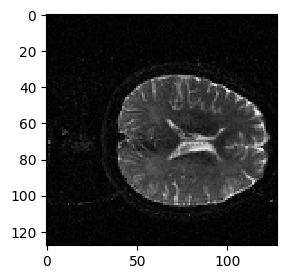

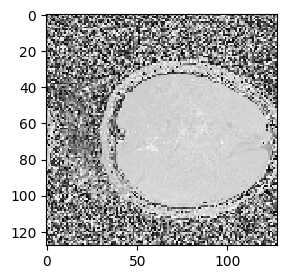

PyObject <matplotlib.image.AxesImage object at 0x2aab3bfdf4e0>

In [9]:
evenkData_acquired_zeroFilled = zeros(Complex128,size(kdata_contrast2));
evenkData_acquired_zeroFilled[:,2:2:end,:] = kdata_contrast2[:,2:2:end,:];
evenimgdata_acquired_zeroFilled = qft(copy(evenkData_acquired_zeroFilled));
evensense_reconstructed_image = zeros(Complex128,size(evenkData_acquired_zeroFilled)[1],size(evenkData_acquired_zeroFilled)[2]);
for cntx = 1:size(evenkData_acquired_zeroFilled)[1]
    for cnty = 1: div(size(evenkData_acquired_zeroFilled)[2],2)
        mat1 = evenimgdata_acquired_zeroFilled[cntx,cnty,:];
        mat2 = hcat(coilSensitivityProfile1[cntx,cnty,:],coilSensitivityProfile1[cntx,cnty+div(size(oddkData_acquired_zeroFilled)[2],2),:])
        mat3 = mat2\mat1;
        evensense_reconstructed_image[cntx,cnty]=mat3[1];
        evensense_reconstructed_image[cntx,cnty+div(size(oddkData_acquired_zeroFilled)[2],2)]=-mat3[2]; # NOTE a minus sign here
    end
end
figure(1,figsize=(3,3));imshow(abs.(evensense_reconstructed_image),cmap="gray")
figure(2,figsize=(3,3));imshow(angle.(evensense_reconstructed_image),cmap="gray")

* __Comparing 2 SENSE produced magnitude images__

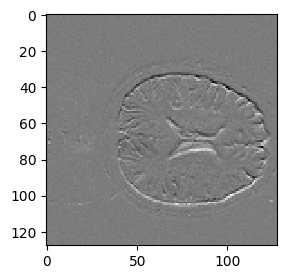

PyObject <matplotlib.image.AxesImage object at 0x2aab3bf12cc0>

In [10]:
figure(1,figsize=(3,3));imshow(abs.(evensense_reconstructed_image)-abs.(oddsense_reconstructed_image),cmap="gray")


* __Saving magnitude data for FSL based image registration__

In [11]:
filename = "data/data_8channel.nii.gz";
headerinfo = load_niigz_header(filename);
headerinfo["dim"][1] = 4
headerinfo["dim"][4] = 1
headerinfo["dim"][5] = 2
headerinfo["datatype"][1]=64
oddimgsave = abs.(oddsense_reconstructed_image);
evenimgsave = abs.(evensense_reconstructed_image);
run(`rm data/images_to_be_aligned.nii`);
newFileName = "data/images_to_be_aligned.nii";
write_nii_header(newFileName, headerinfo);
fid = open(newFileName,"a");
write(fid, oddimgsave);
write(fid, evenimgsave);
close(fid);
